<a href="https://colab.research.google.com/github/johanjun/Google_Machine_Learning_Bootcamp_KR_2021/blob/main/kaggle/RSNA_MICCAI_BRAIN_TUMOR/rsna_miccai_brain_tumor_johanjun_1005_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 4.3 MB/s 


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm
import random
import pydicom
import cv2
import pickle

import matplotlib.pyplot as plt
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [5]:
data_dir = '/content/drive/MyDrive/Google_Machine_Learning_Bootcamp_KR_2021/RSNA_MICCAI/data/rsna-miccai/'

In [6]:
train_df = pd.read_csv(data_dir + "train_labels.csv")
test_df = pd.read_csv(data_dir + "sample_submission.csv")

In this discussion a competition host has notified that there are some issues with these 3 cases
Patient IDs -

1. 00109 (FLAIR images are blank)
2. 00123 (T1w images are blank)
3. 00709 (FLAIR images are blank)
<br><br>Hence these can be excluded

In [7]:
#refer: https://www.kaggle.com/arnabs007/part-1-rsna-miccai-btrc-understanding-the-data
EXCLUDE = [109, 123, 709]
train_df = train_df[~train_df.BraTS21ID.isin(EXCLUDE)]

In [10]:
train_df.head()

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [12]:
cd /content/drive/MyDrive/Google_Machine_Learning_Bootcamp_KR_2021/RSNA_MICCAI/data/rsna-miccai/

/content/drive/MyDrive/Google_Machine_Learning_Bootcamp_KR_2021/RSNA_MICCAI/data/rsna-miccai


In [13]:
train_df = pd.read_csv('train_df(T1wCE).csv')

In [14]:
TYPES = ["FLAIR", "T1w", "T1wCE", "T2w"] #mpMRI scans

In [15]:
def load_dicom(path, size = 128): #load DICOM files
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array #returns a numpy.ndarray containing the pixel data
    if np.max(data) != 0:
        data = data / np.max(data) #standardizes so that the pixel values are between 0 and 1
    data = (data * 255).astype(np.uint8) #rescales to 0 and 255
    return cv2.resize(data, (size, size))

In [16]:
def get_all_image_paths(BraTS21ID, image_type, folder="train"): #get an array of all the images of a particular type or a particular patient id
    assert(image_type in TYPES) #only in types
    patient_path = os.path.join(data_dir + "%s/" % folder, str(BraTS21ID).zfill(5)) #다른 폴더일 수도 있음
    #print(lambda x: int(x[:-4].split("-")[-1]))
    
    paths = sorted(glob.glob(os.path.join(patient_path, image_type, "*")), key=lambda x: int(x[:-4].split("-")[-1])) #sort
    #print(paths)
    
    num_images = len(paths)
    
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)
    if num_images < 10:
        jump = 1
    else:
        jump = 3
        
    return np.array(paths[start:end:jump])

In [17]:
def get_all_images(BraTS21ID, image_type, folder="train", size=225):
    return [load_dicom(path, size) for path in get_all_image_paths(BraTS21ID, image_type, folder)]

In [18]:
def get_all_data_train(image_type):
    global train_df
    
    X = []
    y = []
    train_ids = []

    for i in tqdm(train_df.index):
        tmp_x = train_df.loc[i]
        images = get_all_images(int(tmp_x["BraTS21ID"]), image_type, "train", IMAGE_SIZE)
        label = tmp_x["MGMT_value"]

        X += images
        y += [label] * len(images)
        train_ids += [int(tmp_x["BraTS21ID"])] * len(images)
        assert(len(X) == len(y))
    return np.array(X), np.array(y), np.array(train_ids)

def get_all_data_test(image_type):
    global test_df
    
    X = []
    test_ids = []

    for i in tqdm(test_df.index):
        tmp_x = test_df.loc[i]
        images = get_all_images(int(tmp_x["BraTS21ID"]), image_type, "test", IMAGE_SIZE)
        X += images
        test_ids += [int(tmp_x["BraTS21ID"])] * len(images)

    return np.array(X), np.array(test_ids)

In [21]:
IMAGE_SIZE = 64
X, y, train_idt = get_all_data_train("T1wCE")
X_test, test_idt = get_all_data_test("T1wCE")
X.shape, y.shape, train_idt.shape

 14%|█▎        | 44/321 [17:30<1:50:10, 23.86s/it]


KeyboardInterrupt: ignored

In [ ]:
# #pickling
with open(data_dir+'X_T1wCE_pre.pkl', 'wb') as f:
  pickle.dump(f)

with open(data_dir+'y_T1wCE_pre.pkl', 'wb') as f:
  pickle.dump(f)

with open(data_dir+'train_idt_T1wCE_pre.pkl', 'wb') as f:
  pickle.dump(f)

with open(data_dir+'X_test_T1wCE_pre.pkl', 'wb') as f:
  pickle.dump(f)

with open(data_dir+'test_idt_T1wCE_pre.pkl', 'wb') as f:
  pickle.dump(f)

In [ ]:
# #pickling
# with open(data_dir+'X_T1wCE.pkl', 'rb') as f:
#   X_T1wCE = pickle.load(f)

# with open(data_dir+'y_T1wCE.pkl', 'rb') as f:
#   y_T1wCE = pickle.load(f)

# with open(data_dir+'train_idt_T1wCE.pkl', 'rb') as f:
#   train_idt_T1wCE = pickle.load(f)

# with open(data_dir+'X_test_T1wCE.pkl', 'rb') as f:
#   X_test_T1wCE = pickle.load(f)

# with open(data_dir+'test_idt_T1wCE.pkl', 'rb') as f:
#   test_idt_T1wCE = pickle.load(f)
# #pickling
# with open(data_dir+'X_FLAIR.pkl', 'rb') as f:
#   X_FLAIR = pickle.load(f)

# with open(data_dir+'y_FLAIR.pkl', 'rb') as f:
#   y_FLAIR = pickle.load(f)

# with open(data_dir+'train_idt_FLAIR.pkl', 'rb') as f:
#   train_idt_FLAIR = pickle.load(f)

# with open(data_dir+'X_test_FLAIR.pkl', 'rb') as f:
#   X_test_FLAIR = pickle.load(f)

# with open(data_dir+'test_idt_FLAIR.pkl', 'rb') as f:
#   test_idt_FLAIR = pickle.load(f)
# #pickling
# with open(data_dir+'X_T2w.pkl', 'rb') as f:
#   X_T2w = pickle.load(f)

# with open(data_dir+'y_T2w.pkl', 'rb') as f:
#   y_T2w = pickle.load(f)

# with open(data_dir+'train_idt_T2w.pkl', 'rb') as f:
#   train_idt_T2w = pickle.load(f)

# with open(data_dir+'X_test_T2w.pkl', 'rb') as f:
#   X_test_T2w = pickle.load(f)

# with open(data_dir+'test_idt_T2w.pkl', 'rb') as f:
#   test_idt_T2w = pickle.load(f)
# #pickling
# with open(data_dir+'X_T1w.pkl', 'rb') as f:
#   X_T1w = pickle.load(f)

# with open(data_dir+'y_T1w.pkl', 'rb') as f:
#   y_T1w = pickle.load(f)

# with open(data_dir+'train_idt_T1w.pkl', 'rb') as f:
#   train_idt_T1w = pickle.load(f)

# with open(data_dir+'X_test_T1w.pkl', 'rb') as f:
#   X_test_T1w = pickle.load(f)

# with open(data_dir+'test_idt_T1w.pkl', 'rb') as f:
#   test_idt_T1w = pickle.load(f)

In [ ]:
X_FLAIR.shape, X_T1w.shape, X_T1wCE.shape, X_T2w.shape

((12463, 64, 64), (13004, 64, 64), (16196, 64, 64), (16813, 64, 64))

In [ ]:
# import random

In [ ]:
# np.random.choice(X_FLAIR, 10000)

In [ ]:
X = np.concatenate([X_FLAIR[:4000], X_T1wCE[:4000], X_T2w], axis=0)
y = np.concatenate([y_FLAIR[:4000], y_T1wCE[:4000], y_T2w], axis=0)
train_idt = np.concatenate([train_idt_FLAIR[:4000], train_idt_T1wCE[:4000], train_idt_T2w], axis=0)

X_test = np.concatenate([X_test_FLAIR, X_test_T1w, X_test_T1wCE, X_test_T2w], axis=0)
test_idt = np.concatenate([test_idt_FLAIR, test_idt_T1w, test_idt_T1wCE, test_idt_T2w], axis=0)

In [ ]:
X_train, X_valid, y_train, y_valid, train_idt_train, train_idt_valid = train_test_split(X, y, train_idt, test_size=0.2)

In [ ]:
# X2 = np.concatenate([X_FLAIR, X_T2w, X_T1w, X_T1wCE], axis=0)
# y2 = np.concatenate([y_FLAIR, y_T2w, y_T1w, y_T1wCE], axis=0)
# train_idt2 = np.concatenate([train_idt_FLAIR, train_idt_T2w, train_idt_T1w, train_idt_T1wCE], axis=0)

In [ ]:
# X_train2, X_valid2, y_train2, y_valid2, train_idt_train2, train_idt_valid2 = train_test_split(X2, y2, train_idt2, test_size=0.05)

In [ ]:
X_train = tf.expand_dims(X_train, axis=-1) #expand the dimension at the end of the array
X_valid = tf.expand_dims(X_valid, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)

y_train = to_categorical(y_train) #one-hot incoding
y_valid = to_categorical(y_valid)

In [ ]:
# X_train2 = tf.expand_dims(X_train2, axis=-1) #expand the dimension at the end of the array
# X_valid2 = tf.expand_dims(X_valid2, axis=-1)

# y_train2 = to_categorical(y_train2) #one-hot incoding
# y_valid2 = to_categorical(y_valid2)

In [ ]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, train_idt_train.shape, train_idt_valid.shape

(TensorShape([19850, 64, 64, 1]),
 (19850, 2),
 TensorShape([4963, 64, 64, 1]),
 (4963, 2),
 (19850,),
 (4963,))

In [ ]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='VALID', 
                                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=(2,2)))

    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='VALID'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(2, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01)))
    return model

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
model = EfficientNetB7(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), weights=None, classes=2)

In [ ]:
## Hyper Parameters
IMAGE_SIZE = 64
N_EPOCHS = 60
N_BATCH = 32
N_TRAIN = X_train.shape[0]
N_VAL = X_valid.shape[0]

learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [ ]:
## Create model, compile & summary
model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy', #label이 ohe이 아니면 sparse를 쓰면 자동으로 ohe
              metrics=[tf.keras.metrics.AUC()])

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid, y_valid),
)

Epoch 1/100
404/404 [==============================] - 21s 9ms/step - loss: 7.7023 - auc_1: 0.5836 - val_loss: 5.8669 - val_auc_1: 0.6457
Epoch 2/100
404/404 [==============================] - 3s 8ms/step - loss: 4.8272 - auc_1: 0.6818 - val_loss: 3.9699 - val_auc_1: 0.7073
Epoch 3/100
404/404 [==============================] - 3s 8ms/step - loss: 3.3710 - auc_1: 0.7390 - val_loss: 2.9085 - val_auc_1: 0.7150
Epoch 4/100
404/404 [==============================] - 3s 8ms/step - loss: 2.4819 - auc_1: 0.7924 - val_loss: 2.2412 - val_auc_1: 0.7270
Epoch 5/100
404/404 [==============================] - 3s 8ms/step - loss: 1.8927 - auc_1: 0.8476 - val_loss: 1.7782 - val_auc_1: 0.7805
Epoch 6/100
404/404 [==============================] - 3s 8ms/step - loss: 1.4928 - auc_1: 0.8904 - val_loss: 1.5238 - val_auc_1: 0.7675
Epoch 7/100
404/404 [==============================] - 3s 8ms/step - loss: 1.1956 - auc_1: 0.9292 - val_loss: 1.3492 - val_auc_1: 0.7837
Epoch 8/100
404/404 [===================

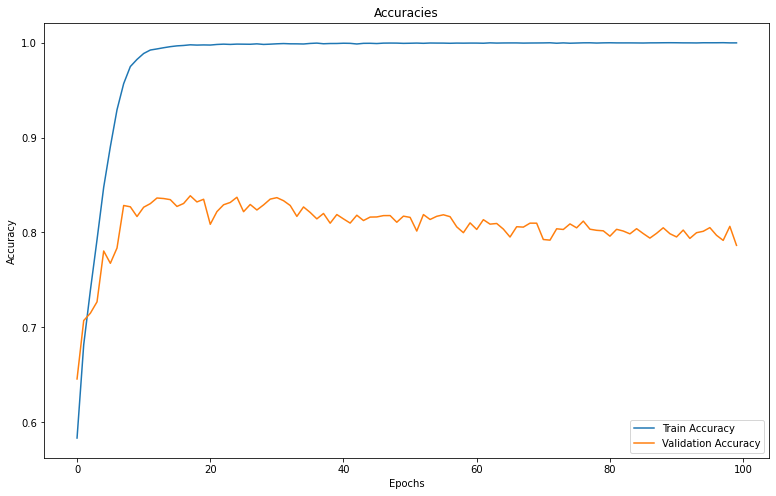

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history["auc_1"], label = "Train Accuracy")
plt.plot(history.history["val_auc_1"],label = "Validation Accuracy")
plt.title("Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

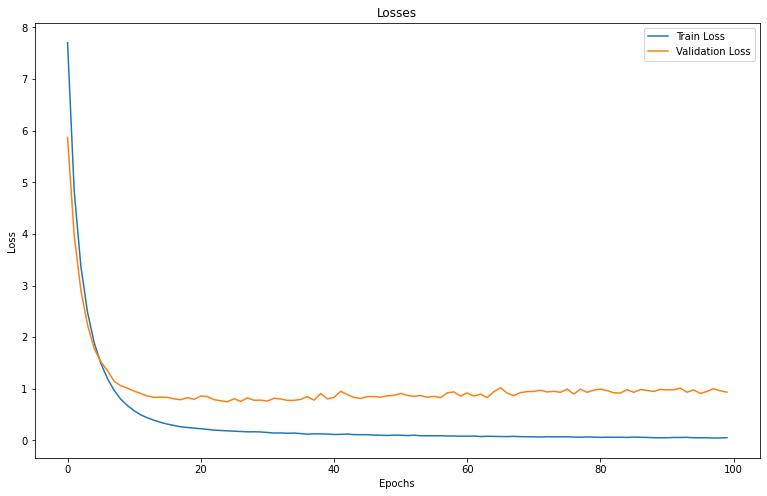

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#0.4 : 0.4 : 1
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid, y_valid),
)

Epoch 1/100
620/620 [==============================] - 6s 9ms/step - loss: 6.9246 - auc_2: 0.6398 - val_loss: 4.7534 - val_auc_2: 0.7328
Epoch 2/100
620/620 [==============================] - 5s 8ms/step - loss: 3.6574 - auc_2: 0.7564 - val_loss: 2.8090 - val_auc_2: 0.7752
Epoch 3/100
620/620 [==============================] - 5s 8ms/step - loss: 2.2572 - auc_2: 0.8169 - val_loss: 1.8665 - val_auc_2: 0.8126
Epoch 4/100
620/620 [==============================] - 5s 8ms/step - loss: 1.5271 - auc_2: 0.8744 - val_loss: 1.3583 - val_auc_2: 0.8458
Epoch 5/100
620/620 [==============================] - 5s 8ms/step - loss: 1.1110 - auc_2: 0.9149 - val_loss: 1.0513 - val_auc_2: 0.8807
Epoch 6/100
620/620 [==============================] - 5s 8ms/step - loss: 0.8523 - auc_2: 0.9429 - val_loss: 0.9142 - val_auc_2: 0.8775
Epoch 7/100
620/620 [==============================] - 5s 8ms/step - loss: 0.6766 - auc_2: 0.9639 - val_loss: 0.8140 - val_auc_2: 0.8814
Epoch 8/100
620/620 [====================

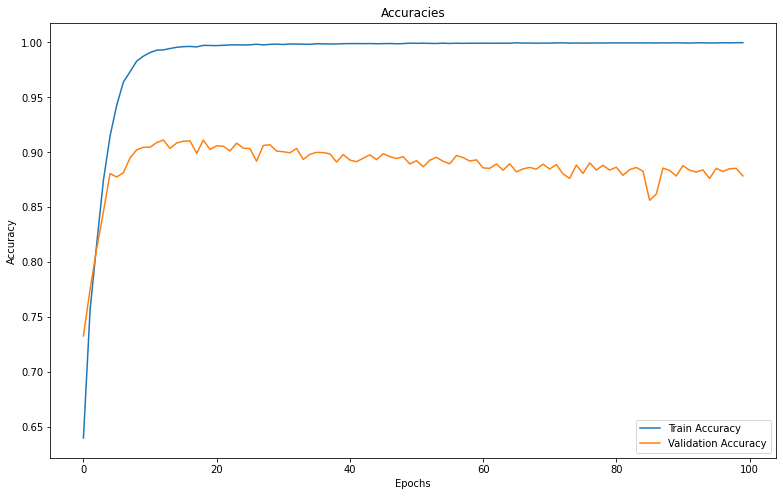

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history["auc_2"], label = "Train Accuracy")
plt.plot(history.history["val_auc_2"],label = "Validation Accuracy")
plt.title("Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

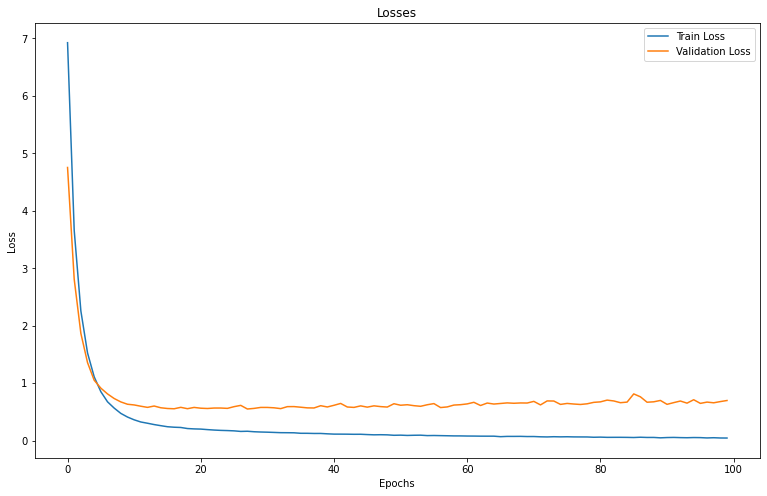

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid, y_valid),
)

Epoch 1/60
620/620 [==============================] - 12s 17ms/step - loss: 6.5056 - auc_3: 0.6921 - val_loss: 3.6615 - val_auc_3: 0.7268
Epoch 2/60
620/620 [==============================] - 10s 16ms/step - loss: 2.4114 - auc_3: 0.8683 - val_loss: 1.7248 - val_auc_3: 0.8494
Epoch 3/60
620/620 [==============================] - 10s 16ms/step - loss: 1.2182 - auc_3: 0.9525 - val_loss: 1.1112 - val_auc_3: 0.8966
Epoch 4/60
620/620 [==============================] - 10s 16ms/step - loss: 0.7681 - auc_3: 0.9823 - val_loss: 0.8549 - val_auc_3: 0.9242
Epoch 5/60
620/620 [==============================] - 10s 16ms/step - loss: 0.5782 - auc_3: 0.9909 - val_loss: 0.7731 - val_auc_3: 0.9182
Epoch 6/60
620/620 [==============================] - 10s 16ms/step - loss: 0.4884 - auc_3: 0.9930 - val_loss: 0.7645 - val_auc_3: 0.9093
Epoch 7/60
620/620 [==============================] - 10s 16ms/step - loss: 0.4393 - auc_3: 0.9947 - val_loss: 0.6791 - val_auc_3: 0.9258
Epoch 8/60
620/620 [==============

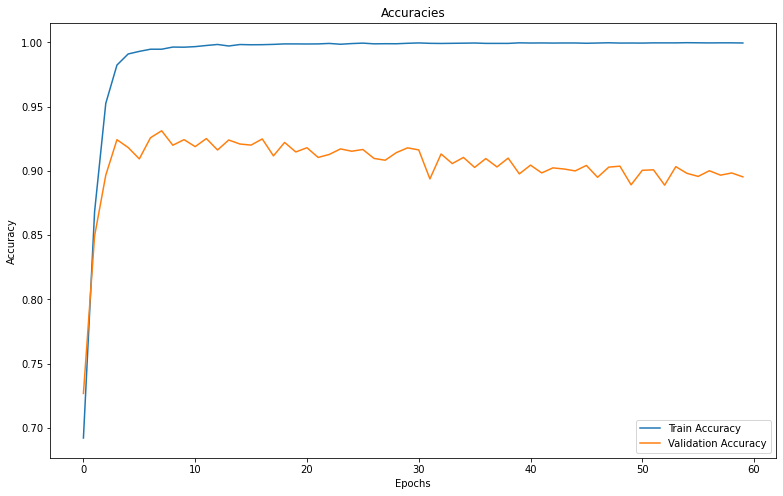

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history["auc_3"], label = "Train Accuracy")
plt.plot(history.history["val_auc_3"],label = "Validation Accuracy")
plt.title("Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

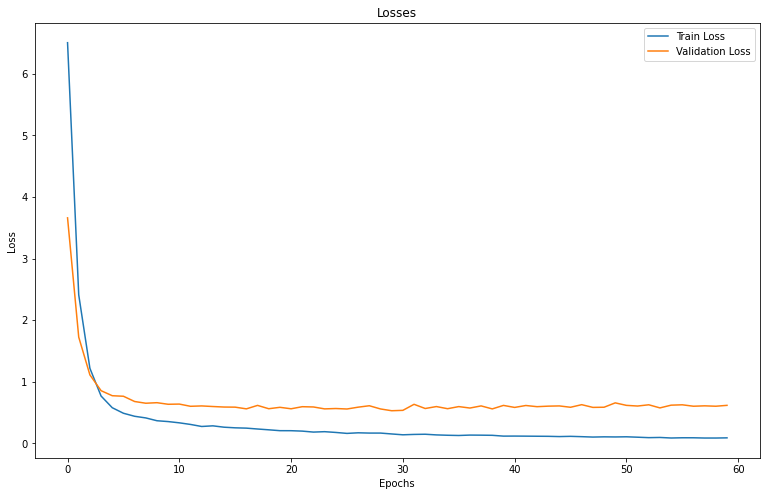

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#effi B7
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid, y_valid),
)

Epoch 1/60
620/620 [==============================] - 11s 17ms/step - loss: 6.6009 - auc_4: 0.6708 - val_loss: 3.7604 - val_auc_4: 0.7377
Epoch 2/60
620/620 [==============================] - 10s 16ms/step - loss: 2.5201 - auc_4: 0.8441 - val_loss: 1.7522 - val_auc_4: 0.8621
Epoch 3/60
620/620 [==============================] - 10s 16ms/step - loss: 1.2654 - auc_4: 0.9453 - val_loss: 1.1292 - val_auc_4: 0.8955
Epoch 4/60
620/620 [==============================] - 10s 16ms/step - loss: 0.7854 - auc_4: 0.9810 - val_loss: 0.8996 - val_auc_4: 0.9074
Epoch 5/60
620/620 [==============================] - 10s 16ms/step - loss: 0.5817 - auc_4: 0.9909 - val_loss: 0.7880 - val_auc_4: 0.9134
Epoch 6/60
620/620 [==============================] - 10s 16ms/step - loss: 0.4791 - auc_4: 0.9934 - val_loss: 0.7278 - val_auc_4: 0.9180
Epoch 7/60
620/620 [==============================] - 10s 16ms/step - loss: 0.4315 - auc_4: 0.9946 - val_loss: 0.7248 - val_auc_4: 0.9097
Epoch 8/60
620/620 [==============

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history["auc_4"], label = "Train Accuracy")
plt.plot(history.history["val_auc_4"],label = "Validation Accuracy")
plt.title("Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_valid) #pedict on X_valid
pred = np.argmax(y_pred, axis = 1) #index of largest value by column 열 기준 가장 큰 값의 인덱스

result = pd.DataFrame(train_idt_valid) #BraTS21ID
result[1] = pred #MGMT_value
result.columns=["BraTS21ID","MGMT_value"]

In [ ]:
#Group by BraTS21ID and average + do not use index
result_final = result.groupby("BraTS21ID", as_index = False).mean()
result_final = result_final.merge(train_df, on = "BraTS21ID") #merge train_df

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(result_final.MGMT_value_y, result_final.MGMT_value_x,)

0.8986320815589108

In [ ]:
X_test2 = tf.expand_dims(X_test, axis=-1)

In [ ]:
#submission
sample_sub = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv")

y_pred = model.predict(X_test2) #predict test
pred = np.argmax(y_pred, axis = 1)

result = pd.DataFrame(test_idt)
result[1] = pred

result.columns=["BraTS21ID","MGMT_value"]
result_final = result.groupby("BraTS21ID",as_index = False).mean()

result_final["BraTS21ID"] = sample_sub["BraTS21ID"]
result_final["MGMT_value"] = result_final["MGMT_value"]
result_final

,BraTS21ID,MGMT_value
0,1,0.909091
1,13,0.909091
2,15,0.901961
3,27,0.921569
4,37,0.954545
...,...,...
82,826,0.857143
83,829,0.800000
84,833,0.375000
85,997,0.500000


In [ ]:
result_final.to_csv("submission.csv",index=False)